In [1]:
# Run the cell and select the kaggle.json file downloaded
# from the kaggle account settings page

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunnypaul","key":"e59b040de04a0649c7f45071294dc388"}'}

we will start by connecting to kaggle using kaggle API which can be downloaded from your kaggle accounts settings and uploading it here (upload box)

In [2]:
# Next, install the kaggle API client. 
!pip install -q kaggle

In [3]:
# The kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on kaggle tool startup. 
!chmod 600 ~/.kaggle/kaggle.json 


In [5]:
# Creating directory and changing the current working directory 

!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [6]:
# Searching for dataset

!kaggle datasets list -s dogbreedidfromcomp 

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05            583  


In [7]:
# Downloading dataset and coming out of directory 

!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd .. 

100% 688M/691M [00:07<00:00, 69.8MB/s]
100% 691M/691M [00:07<00:00, 93.6MB/s]
/content


In [8]:
# Unzipping downloaded file and removing unusable file 

!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [23]:
# Important library imports

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm 
from keras.preprocessing import image 
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [12]:
# Read the labels.csv file and checking shape and records

labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
# Visualize the number of each breeds 

breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [15]:
# Selecting first 3 breeds (Limitation due to computation power)

CLASS_NAMES = ['scottish_deerhound', 'maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [18]:
# Creating numpy matrix with zeros 

x_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')

#One hot encoding
y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset 
for i in tqdm(range(len(labels))):
  img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
  img = image.img_to_array(img)
  x = np.expand_dims(img.copy(), axis=0)
  x_data[i] = x/255.0

# Printing train image and one hot encode shape & size
print('\nTrain Image shape: ', x_data.shape,' size:{:,}'.format(x_data.size))
print('One-hot encoded outout shape: ', y_data.shape, 'size:{:,}'.format(y_data.size))

100%|██████████| 357/357 [00:01<00:00, 220.21it/s]


Train Image shape:  (357, 224, 224, 3)  size:53,738,496
One-hot encoded outout shape:  (357, 3) size:1,071


In [24]:
# Building the model 

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer ='l2'))
model.add(MaxPool2D(pool_size=(2,2))) 

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation = 'relu', kernel_regularizer ='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation = 'relu', kernel_regularizer ='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(64, activation = 'relu', kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 16)      

here we create a network architechture for the model. we have used different types of layers according to their features namely conv_2d (it is used to create a convolutional kernel that convolved with the input layer to produce the output tensor), max_pooling2d(it is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten(it flattens the input and creates a 1D output), Dense( Dense layer produce the output as the dot product of input and kernel)
After defining the network architechture we found out the total parameters as 162,619.

In [25]:
# Splitting the data set into training and testing data sets
x_train_and_val, x_test, y_train_and_val, y_test = train_test_split(x_data, y_data, test_size = 0.1)

# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train_and_val, y_train_and_val, test_size = 0.2)

After defining the network architechture we will start with splitting the test and train data then dividing train data in train and validation data

In [26]:
# Training the model 
epochs = 100
batch_size = 128

history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/100
2/2 [==============================] - 39s 20s/step - loss: 4.8943 - accuracy: 0.3281 - val_loss: 4.8748 - val_accuracy: 0.3077
Epoch 2/100
2/2 [==============================] - 32s 17s/step - loss: 4.8668 - accuracy: 0.3516 - val_loss: 4.8498 - val_accuracy: 0.3077
Epoch 3/100
2/2 [==============================] - 32s 17s/step - loss: 4.8408 - accuracy: 0.3516 - val_loss: 4.8248 - val_accuracy: 0.2923
Epoch 4/100
2/2 [==============================] - 32s 17s/step - loss: 4.8143 - accuracy: 0.3555 - val_loss: 4.7985 - val_accuracy: 0.2923
Epoch 5/100
2/2 [==============================] - 32s 17s/step - loss: 4.7884 - accuracy: 0.3633 - val_loss: 4.7730 - val_accuracy: 0.3077
Epoch 6/100
2/2 [==============================] - 32s 17s/step - loss: 4.7627 - accuracy: 0.3633 - val_loss: 4.7481 - val_accuracy: 0.3077
Epoch 7/100
2/2 [==============================] - 32s 17s/step - loss: 4.7368 - accuracy: 0.3555 - val_loss: 4.7239 - val_accuracy: 0.2923
Epoch 8/100
2/2 [===

Now we will train our model on 100 epochs and a batch size of 128. you can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

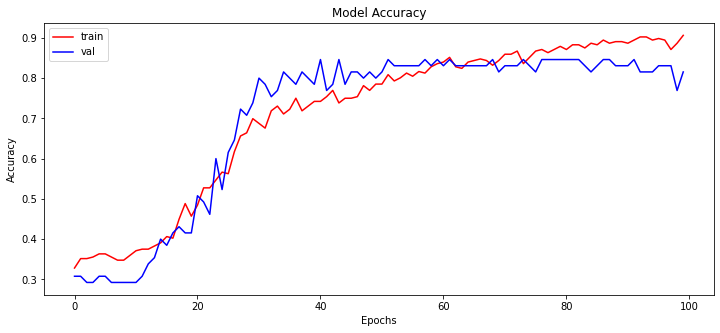

In [27]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Here we analyse how the model is learning with each epoch in terms of accuracy.

In [28]:
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test)
print('Accuracy over the test set:  \n', round((score[1]*100), 2), '%')

2/2 [==============================] - 1s 158ms/step - loss: 2.9426 - accuracy: 0.8611
Accuracy over the test set:  
 86.11 %


WE will use predict function to make predictions using this model also we are finding out the accuracy on the test set. 

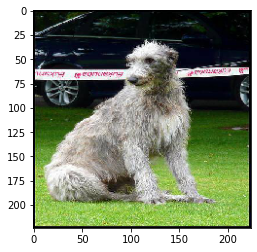

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [31]:
# Plotting image to compare

plt.imshow(x_test[10,:,:,:])
plt.show()

# Finding max value from prediction list and comparing original value vs predicted

print("Originally : ", labels['breed'][np.argmax(y_test[10])])
print("Predicted : ", labels['breed'][np.argmax(y_pred[10])])